<img src="https://www.luxonis.com/logo.svg" width="400">

# DataDreamer Tutorial: Generating a dataset for object detection, training a model, and deploying it to the OAK

Install the required dependencies.

In [ ]:
!pip install datadreamer

## 🗃️ Generate a dataset with your own classes (might take some time to download all models)

Make sure you are using the GPU runtime type (in Google Colab).

~8 min to generate 100 images

~2 min to annotate them

In [ ]:
!datadreamer --save_dir generated_dataset \
             --class_names robot tractor horse car person bear \
             --prompts_number 100 \
             --disable_lm_filter \
             --prompt_generator simple \
             --num_objects_range 2 3 \
             --image_generator sdxl-turbo \
             --use_tta \
             --image_annotator owlv2 \
             --conf_threshold 0.15 \
             --vis_anns \
             --seed 42

### Parameters
- `--save_dir` (required): Path to the directory for saving generated images and annotations.
- `--class_names` (required): Space-separated list of object names for image generation and annotation. Example: `person moon robot`.
- `--prompts_number` (optional): Number of prompts to generate for each object. Defaults to `10`.
- `--annotate_only` (optional): Only annotate the images without generating new ones, prompt and image generator will be skipped. Defaults to `False`.
- `--task`: Choose between `detection`, `classification` and `instance-segmentation`. Default is `detection`.
- `--dataset_format`: Format of the dataset. Defaults to `raw`. Supported values: `raw`, `yolo`, `coco`, `voc`, `luxonis-dataset`, `cls-single`.
- `--split_ratios`: Split ratios for train, validation, and test sets. Defaults to `[0.8, 0.1, 0.1]`.
- `--num_objects_range`: Range of objects in a prompt. Default is 1 to 3.
- `--prompt_generator`: Choose between `simple`, `lm` (Mistral-7B), `tiny` (tiny LM), and `qwen2` (Qwen2.5 LM). Default is `qwen2`.
- `--image_generator`: Choose image generator, e.g., `sdxl`, `sdxl-turbo`, `sdxl-lightning` or `shuttle-3`. Default is `sdxl-turbo`.
- `--image_annotator`: Specify the image annotator, like `owlv2` for object detection or `aimv2` or `clip` for image classification or `owlv2-slimsam` and `owlv2-sam2` for instance segmentation. Default is `owlv2`.
- `--conf_threshold`: Confidence threshold for annotation. Default is `0.15`.
- `--annotation_iou_threshold`: Intersection over Union (IoU) threshold for annotation. Default is `0.2`.
- `--prompt_prefix`: Prefix to add to every image generation prompt. Default is `""`.
- `--prompt_suffix`: Suffix to add to every image generation prompt, e.g., for adding details like resolution. Default is `", hd, 8k, highly detailed"`.
- `--negative_prompt`: Negative prompts to guide the generation away from certain features. Default is `"cartoon, blue skin, painting, scrispture, golden, illustration, worst quality, low quality, normal quality:2, unrealistic dream, low resolution,  static, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, bad anatomy"`.
- `--use_tta`: Toggle test time augmentation for object detection. Default is `False`.
- `--synonym_generator`: Enhance class names with synonyms. Default is `none`. Other options are `llm`, `wordnet`.
- `--use_image_tester`: Use image tester for image generation. Default is `False`.
- `--image_tester_patience`: Patience level for image tester. Default is `1`.
- `--lm_quantization`: Quantization to use for Mistral language model. Choose between `none` and `4bit`. Default is `none`.
- `--annotator_size`: Size of the annotator model to use. Choose between `base` and `large`. Default is `base`.
- `--disable_lm_filter`: Use only a bad word list for profanity filtering. Default is `False`.
- `--keep_unlabeled_images`: Whether to keep images without any annotations. Default if `False`.
- `--batch_size_prompt`: Batch size for prompt generation. Default is 64.
- `--batch_size_annotation`: Batch size for annotation. Default is `1`.
- `--batch_size_image`: Batch size for image generation. Default is `1`.
- `--raw_mask_format`: Format of segmentations masks when saved in raw dataset format. Default is `rle`.
- `--vis_anns`: Whether to save visualizations of annotations. Default is `False`.
- `--device`: Choose between `cuda` and `cpu`. Default is `cuda`.
- `--seed`: Set a random seed for image and prompt generation. Default is `42`.
- `--config`: A path to an optional `.yaml` config file specifying the pipeline's arguments.


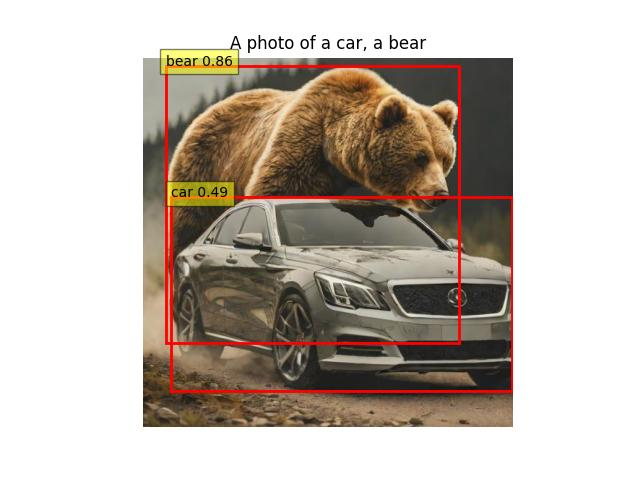

In [ ]:
import os

from IPython.display import Image

Image(filename=os.path.join("generated_dataset/bboxes_visualization", "bbox_0000070.jpg"))

## ✍ Convert the dataset to YOLO format

In [ ]:
from datadreamer.utils.convert_dataset import convert_dataset

In [ ]:
convert_dataset(
    input_dir="generated_dataset",
    output_dir="generated_dataset_yolo",
    dataset_format="yolo",
    split_ratios=[0.8, 0.1, 0.1],
    copy_files=True,
)

In [ ]:
!ls generated_dataset_yolo

data.yaml  test  train	val


## 🏋️‍♂️ Train your model (YOLOv8 as an example)

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # load a pretrained model

In [ ]:
results = model.train(data="generated_dataset_yolo/data.yaml", epochs=50)

### 🧠 Show the predictions

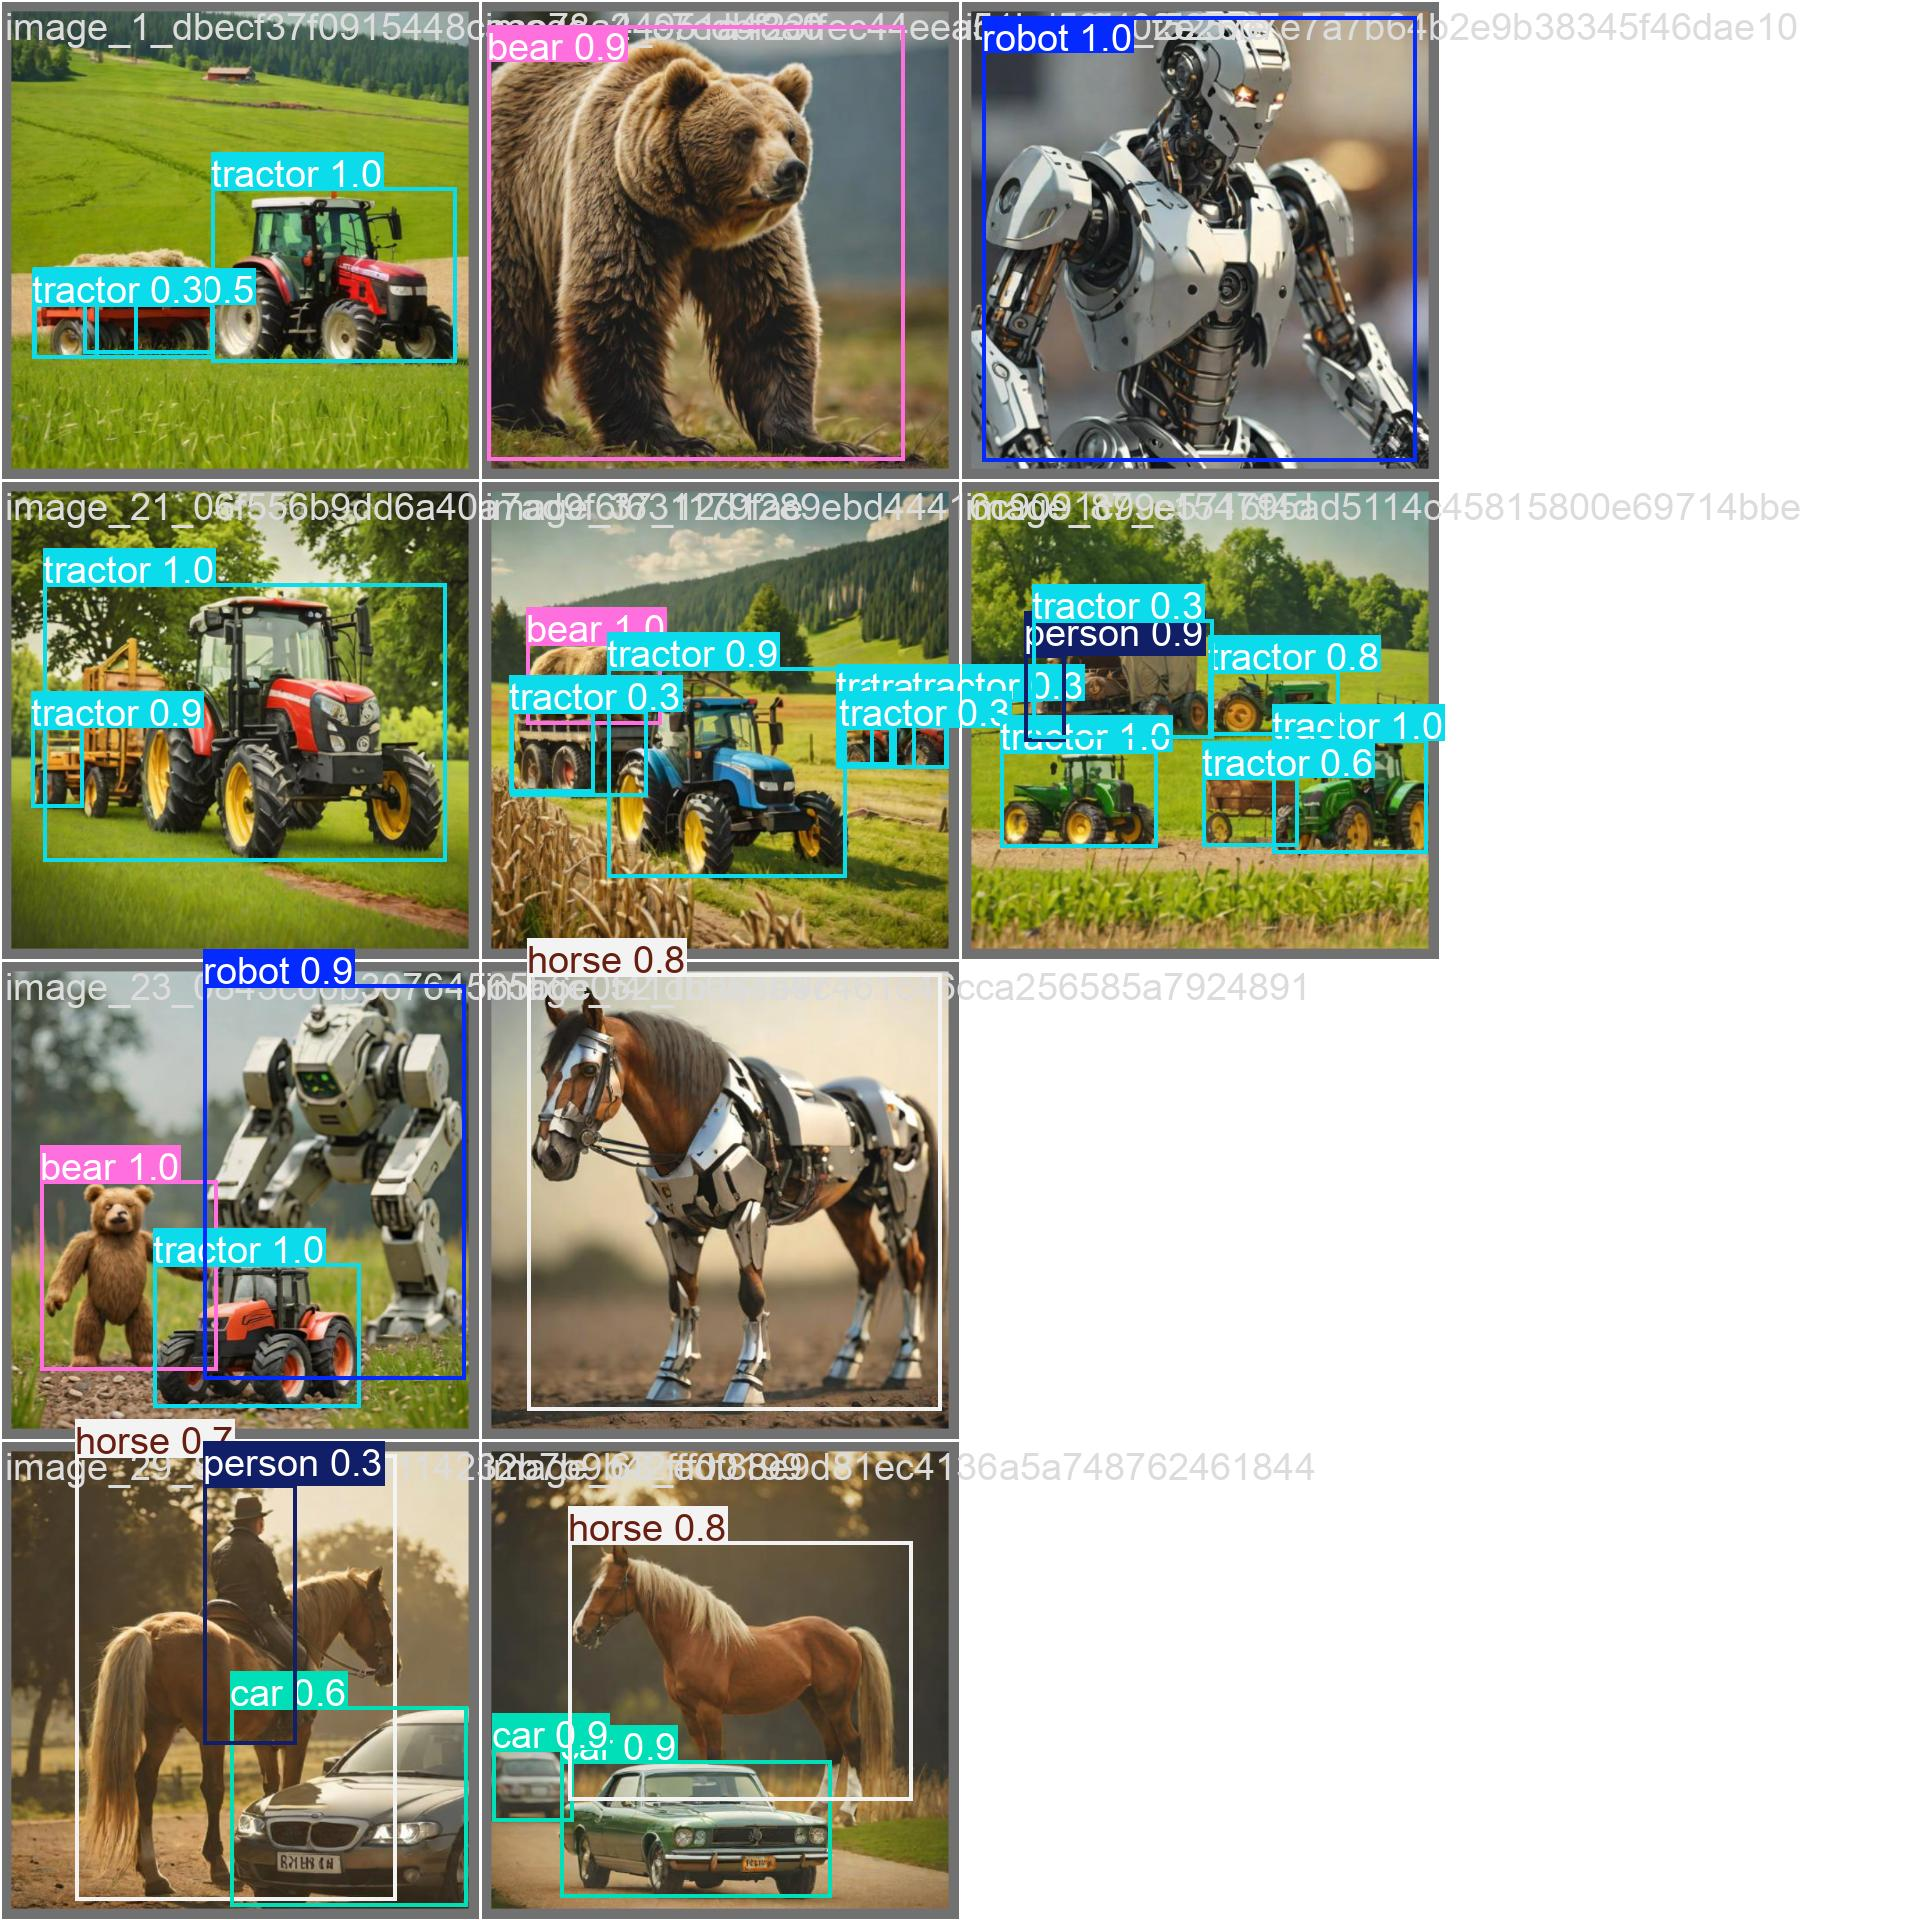

In [10]:
Image(filename=os.path.join(results.save_dir, "val_batch0_pred.jpg"))

In [11]:
metrics = model.val()

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/generated_dataset_yolo/val/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


                   all         10         30      0.862      0.784      0.838      0.683
                 robot          2          3      0.791      0.667      0.736      0.675
               tractor          5         13      0.681      0.824      0.843      0.704
                 horse          3          4      0.877       0.75      0.746      0.508
                   car          2          4          1      0.845      0.995       0.83
                person          3          3          1      0.616      0.712      0.417
                  bear          3          3      0.825          1      0.995      0.962
Speed: 2.0ms preprocess, 9.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2


## 💾 Weights Download

By default, the library saves the weights with the best performance into the `best.pt` file inside the corresponding run folder. We'll rename it to reflect the model better.

In [15]:
!cp runs/detect/train/weights/best.pt yolov8n_trained_datadreamer.pt

We'll download the weights to convert them in the next step.

In [ ]:
from google.colab import files
files.download("yolov8n_trained_datadreamer.pt")

<a name="conversion"></a>

## 🗂️ Conversion

We have the trained model, and the goal is to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. To simplify the process, we recommend you use our [`HubAI`](https://hub.luxonis.com) platform. You can log in, navigate to the AI section, and click the `+ Add Model` button. 

Please select `YOLO` as a model type.

<img src="./media/hub_model_type.png" alt="HubAI model type selection" width="640">

Then, choose your desired target platform (RVC2, RVC3, or RVC4). In our case, we will use RVC2.

<img src="./media/hubai_target_platform.png" alt="HubAI model platform selection" width="640">

Then, fill out the form on the image below with the information about your model.

<img src="./media/model_upload.png" alt="Exported model on HubAI" width="640">

After that, fill in specific information about the RVC2 export.

Here are the class names for you to copy:
```
robot,tractor,horse,car,person,bear
```

<img src="./media/rvc2.png" alt="Exported model on HubAI" width="640">

Choose the input image size. In our case, we will use `512x288`.

<img src="./media/yolo_rvc2_shape.png" alt="Exported model on HubAI" width="640">

Finally, click `Export` and wait for the model to be converted. The process might take some time, but after it's finished, we can download the model and use it with our DepthAI script. We'll use RVC2 in this tutorial, but you can follow the same process for other versions. All that is left to do is create a DepthAI script and deploy the model to the device. We already made such an example below. There are two variables that you need to populate, though:
- `ModelSlug`: This is a string representation of your model version based on which DepthAI can download it. You can get it by clicking the `Copy` button next to the `Convert` you used before.
- `ApiToken`: Since this model is private to your team, you need a token to access it. To generate the token, we navigate to team settings and click `+ Create API Token`. We then copy and paste it into the script below. 

<img src="./media/yolo_model.png" alt="Exported model on HubAI" width="800">

In [ ]:
MODEL_SLUG = "insert_your_model_slug_here" # TODO: Insert your model slug
API_TOKEN = "insert_your_token_here" # TODO: Insert your API Token

<a name="depthai-script"></a>

## 📷 DepthAI Script

In [ ]:
!pip install -q --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a13

Finally, here's the script to run the YOLOv8 model on a device using DepthAI:

In [ ]:
import cv2
import depthai as dai
import numpy as np
import time
import os

os.environ["DEPTHAI_HUB_API_KEY"] = API_TOKEN

labels = ["robot", "tractor", "horse", "car", "person", "bear"]

device = dai.Device()
platform = device.getPlatform()

model = dai.NNArchive(dai.getModelFromZoo(dai.NNModelDescription(MODEL_SLUG, platform.name)))
with dai.Pipeline(device) as pipeline:
# with dai.Pipeline() as pipeline:
    camera_node = pipeline.create(dai.node.Camera).build()
    detection_nn = pipeline.create(dai.node.DetectionNetwork).build(camera_node, model)

    frame_queue = detection_nn.passthrough.createOutputQueue()
    detection_queue = detection_nn.out.createOutputQueue()

    pipeline.start()

    while pipeline.isRunning():
        frame: np.ndarray = frame_queue.get().getCvFrame()
        nn_output: dai.ImgDetections = detection_queue.get()

        for detection in nn_output.detections:
            xmin, ymin, xmax, ymax = (
                detection.xmin,
                detection.ymin,
                detection.xmax,
                detection.ymax,
            )

            xmin = int(xmin * frame.shape[1])
            ymin = int(ymin * frame.shape[0])
            xmax = int(xmax * frame.shape[1])
            ymax = int(ymax * frame.shape[0])

            cv2.rectangle(
                frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2
            )
            cv2.putText(
                frame,
                f"{detection.confidence * 100:.2f}%",
                (int(xmin) + 10, int(ymin) + 20),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                255,
            )
            cv2.putText(
                frame,
                # str(detection.label),
                labels[detection.label],
                (int(xmin) + 10, int(ymin) + 40),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                255,
            )

        cv2.imshow("Detections", frame)
        key = cv2.waitKey(1)
        if key == ord("q"):
            pipeline.stop()
            break
